In [2]:
import torch
import torch.nn as nn
import torch.functional as F
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import Counter


import re
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
!git clone https://github.com/wangshusen/GIANT-Python-Code.git

fatal: destination path 'GIANT-Python-Code' already exists and is not an empty directory.


In [5]:
import os

# Check that the repo exists in your current working directory
os.listdir("GIANT-Python-Code")[:10]

['.git',
 '.gitignore',
 'Algorithm',
 'ExperimentLogistic',
 'ExperimentQuadratic',
 'LICENSE',
 'LinuxSetup.sh',
 'README.md',
 'Resource',
 'Util']

In [ ]:
import glob
import py_compile
import os

# Change this to your repository’s root folder
repo_path = "GIANT-Python-Code"

# Find all .py files inside the repo (recursively)
python_files = [f for f in glob.glob(os.path.join(repo_path, "**", "*.py"), recursive=True) if os.path.isfile(f)]

print(f"Found {len(python_files)} .py files")
print("Example files:\n", python_files[:10])

compiled_count = 0
for file in python_files:
    try:
        py_compile.compile(file, cfile=file + "c", doraise=True)
        compiled_count += 1
    except (py_compile.PyCompileError, PermissionError) as e:
        print(f"Failed to compile: {file}\nError: {e}")

print(f"\nSuccessfully compiled {compiled_count}/{len(python_files)} Python files.")

Found 17 .py files
Example files:
 ['GIANT-Python-Code\\Algorithm\\ExecutorLogistic.py', 'GIANT-Python-Code\\Algorithm\\ExecutorQuadratic.py', 'GIANT-Python-Code\\Algorithm\\Solver.py', 'GIANT-Python-Code\\ExperimentLogistic\\demo.py', 'GIANT-Python-Code\\ExperimentLogistic\\experiment1.py', 'GIANT-Python-Code\\ExperimentLogistic\\experiment1ec2.py', 'GIANT-Python-Code\\ExperimentLogistic\\experiment2.py', 'GIANT-Python-Code\\ExperimentQuadratic\\demo.py', 'GIANT-Python-Code\\ExperimentQuadratic\\experiment1.py', 'GIANT-Python-Code\\ExperimentQuadratic\\experiment2.py']

Successfully compiled 17/17 Python files.


In [7]:
import os

combined_python_text = ""

for file in python_files:
    if not os.path.isfile(file):
        continue  # Skip directories just in case
    try:
        with open(file, "r", encoding="utf-8", errors="ignore") as f:
            combined_python_text += f.read() + "\n\n"
    except PermissionError:
        print(f"Skipping (no permission): {file}")
    except Exception as e:
        print(f"Skipping {file} due to error: {e}")

print(f"\n Combined {len(python_files)} Python files into a single text string.")
print(f"Total combined text length: {len(combined_python_text):,} characters")


 Combined 17 Python files into a single text string.
Total combined text length: 55,501 characters


In [17]:
import re
import pandas as pd
from collections import Counter

# Use your existing in-memory string
python_text = combined_python_text  # already combined earlier

# Tokenize: match identifiers, keywords, numbers, and punctuation
tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];.,=+\-*/<>!&|^%~?:]', python_text)

# Count token frequencies
token_counts = Counter(tokens)
df_counts = pd.DataFrame(token_counts.items(), columns=["token", "frequency"])
df_counts = df_counts.sort_values(by="frequency", ascending=False)

# Show stats
print("Total tokens:", len(tokens))
print("Unique tokens:", len(df_counts))

print("\nTop 20 most frequent tokens:\n")
print(df_counts.head(20).to_string(index=False))

# Optionally save vocabulary to CSV for later reuse
df_counts.to_csv("python_vocabulary.csv", index=False)
print("Saved token frequencies to python_vocabulary.csv")


Total tokens: 13628
Unique tokens: 521

Top 20 most frequent tokens:

   token  frequency
       =       1582
       ,       1292
       .       1019
       )        970
       (        970
   numpy        275
       +        268
    self        264
       :        227
       -        202
       [        179
       ]        179
       m        158
       d        132
       *        130
     plt        125
dataname        111
       /        100
       n         96
       X         95
Saved token frequencies to python_vocabulary.csv


In [18]:
import torch

# Create mappings (string ↔ integer)
stoi = {s: i for i, s in enumerate(df_counts["token"])}
itos = {i: s for s, i in stoi.items()}

# Define context size (how many previous tokens to use for prediction)
context_size = 5  # you can adjust between 3–10

# Prepare X (context) and Y (target) lists
X, Y = [], []

for i in range(len(tokens) - context_size):
    context = tokens[i:i + context_size]
    target = tokens[i + context_size]
    X.append([stoi[t] for t in context])
    Y.append(stoi[target])

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

print(f"Created {len(X):,} training samples")
print(f"Input tensor shape: {X.shape}")
print(f"Target tensor shape: {Y.shape}")

Created 13,623 training samples
Input tensor shape: torch.Size([13623, 5])
Target tensor shape: torch.Size([13623])


In [19]:
# Move to torch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: torch.Size([13623, 5])
Y shape: torch.Size([13623])


C:\Users\Dell\AppData\Local\Temp\ipykernel_10364\58747240.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\Dell\AppData\Local\Temp\ipykernel_10364\58747240.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y)


In [20]:
import torch.nn as nn

class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim=64, hidden_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(context_size * embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(stoi)
model = NextTokenPredictor(vocab_size, context_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

batch_size = 1024
epochs = 1000

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(0, len(X), batch_size):
        x_batch = X[i:i+batch_size].to(device)
        y_batch = Y[i:i+batch_size].to(device)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

torch.save(model, "python_model1.pt")
print("Model training complete and saved!")

Epoch 1/1000, Loss: 76.6452
Epoch 2/1000, Loss: 53.8458
Epoch 3/1000, Loss: 45.8662
Epoch 4/1000, Loss: 40.1118
Epoch 5/1000, Loss: 35.1916
Epoch 6/1000, Loss: 30.9996
Epoch 7/1000, Loss: 27.4127
Epoch 8/1000, Loss: 24.3198
Epoch 9/1000, Loss: 21.6650
Epoch 10/1000, Loss: 19.3706
Epoch 11/1000, Loss: 17.3759
Epoch 12/1000, Loss: 15.6397
Epoch 13/1000, Loss: 14.1234
Epoch 14/1000, Loss: 12.8030
Epoch 15/1000, Loss: 11.6520
Epoch 16/1000, Loss: 10.6785
Epoch 17/1000, Loss: 9.7671
Epoch 18/1000, Loss: 8.9891
Epoch 19/1000, Loss: 8.3075
Epoch 20/1000, Loss: 7.7543
Epoch 21/1000, Loss: 7.1954
Epoch 22/1000, Loss: 6.7426
Epoch 23/1000, Loss: 6.3279
Epoch 24/1000, Loss: 6.0531
Epoch 25/1000, Loss: 5.6604
Epoch 26/1000, Loss: 5.3631
Epoch 27/1000, Loss: 5.0698
Epoch 28/1000, Loss: 4.8429
Epoch 29/1000, Loss: 4.6487
Epoch 30/1000, Loss: 4.5082
Epoch 31/1000, Loss: 4.4512
Epoch 32/1000, Loss: 4.2422
Epoch 33/1000, Loss: 4.0374
Epoch 34/1000, Loss: 3.9652
Epoch 35/1000, Loss: 3.7539
Epoch 36/1000

In [14]:
import torch.nn as nn

class NextTokenPredictor(nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim=32, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(context_size * embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
import torch
from torch.serialization import safe_globals

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with safe_globals([NextTokenPredictor]):
    model = torch.load("python_model1.pt", map_location=device, weights_only=False)

model.to(device)
model.eval()

NextTokenPredictor(
  (embed): Embedding(521, 64)
  (fc1): Linear(in_features=320, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=521, bias=True)
  (activation): ReLU()
)

In [17]:
import random

def generate_next_tokens(model, seed_tokens, num_tokens=10, temperature=1.0):
    model.eval()
    generated = seed_tokens[:]
    for _ in range(num_tokens):
        context = generated[-context_size:]
        x = torch.tensor([[stoi.get(t, 0) for t in context]], device=device)
        logits = model(x) / temperature
        probs = torch.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probs[0], num_samples=1).item()
        next_token = itos[next_token_id]
        generated.append(next_token)
    return " ".join(generated)

# Try generating
# Ask user for input text
user_input = input("Enter starting C++ code snippet: ")

# Tokenize the input properly (C++ syntax-aware)
user_tokens = re.findall(r'[A-Za-z_][A-Za-z0-9_]*|[{}()\[\];.,=+\-*/<>!&|^%~?:]', user_input)

# Handle unknown tokens gracefully
user_tokens = [t for t in user_tokens if t in stoi]
if len(user_tokens) < context_size:
    print(f"Input too short, padding with <unk> tokens")
    user_tokens = ['<unk>'] * (context_size - len(user_tokens)) + user_tokens

# Generate new code continuation
generated_code = generate_next_tokens(model, user_tokens, num_tokens=30, temperature=1.0)

print("\nGenerated continuation:\n")
print(generated_code)

Input too short, padding with <unk> tokens

Generated continuation:

<unk> for i in range ( MaxIter ) : Ap = lam * p + numpy . dot ( A . T , aw ) - b + lam * w the stochastic gradient at


Using device: cpu
✅ Python model loaded successfully!
Embedding size: torch.Size([521, 64])
Embedding matrix shape: (521, 64)


d:\VSCode\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128013 (\N{SNAKE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


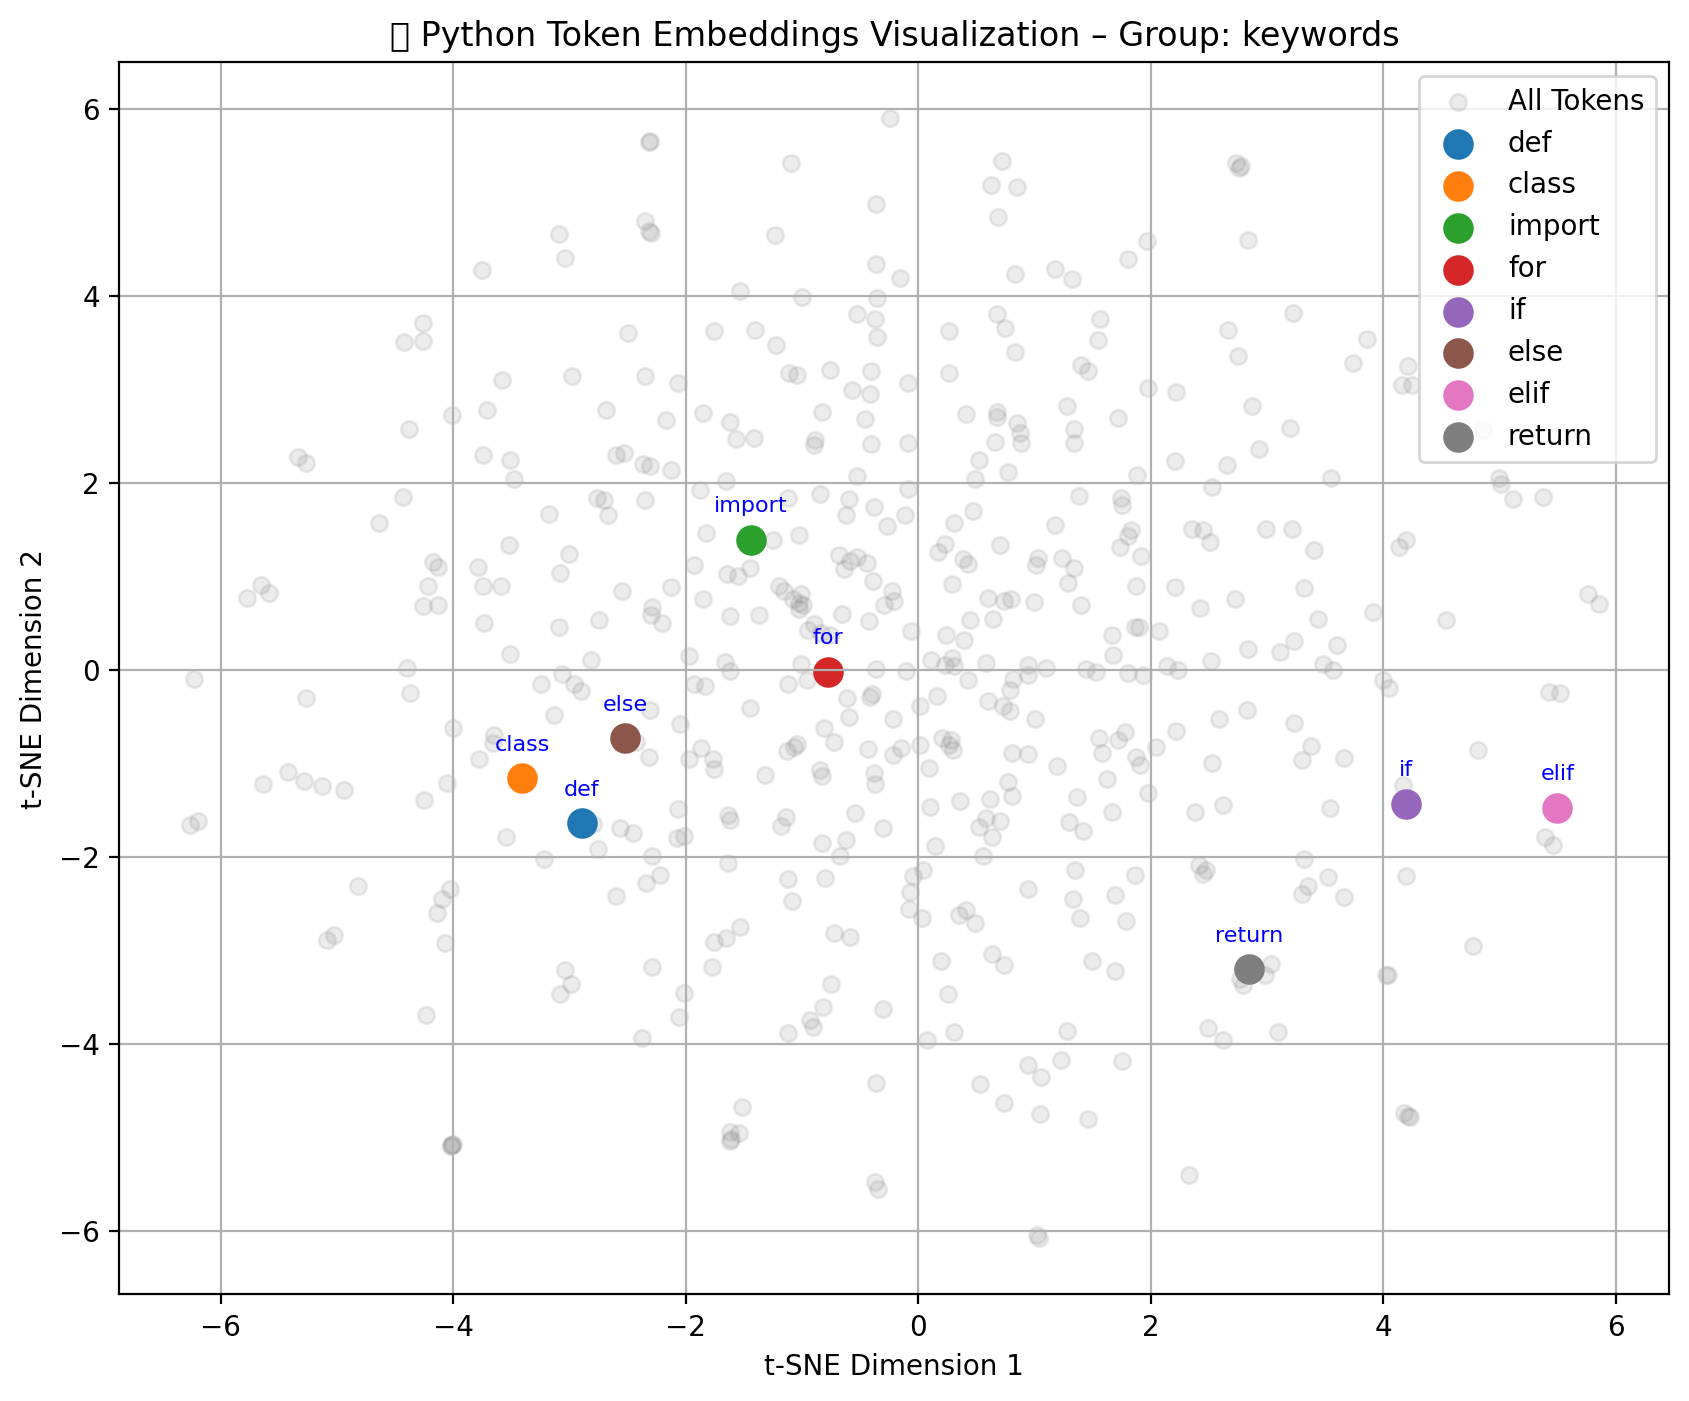

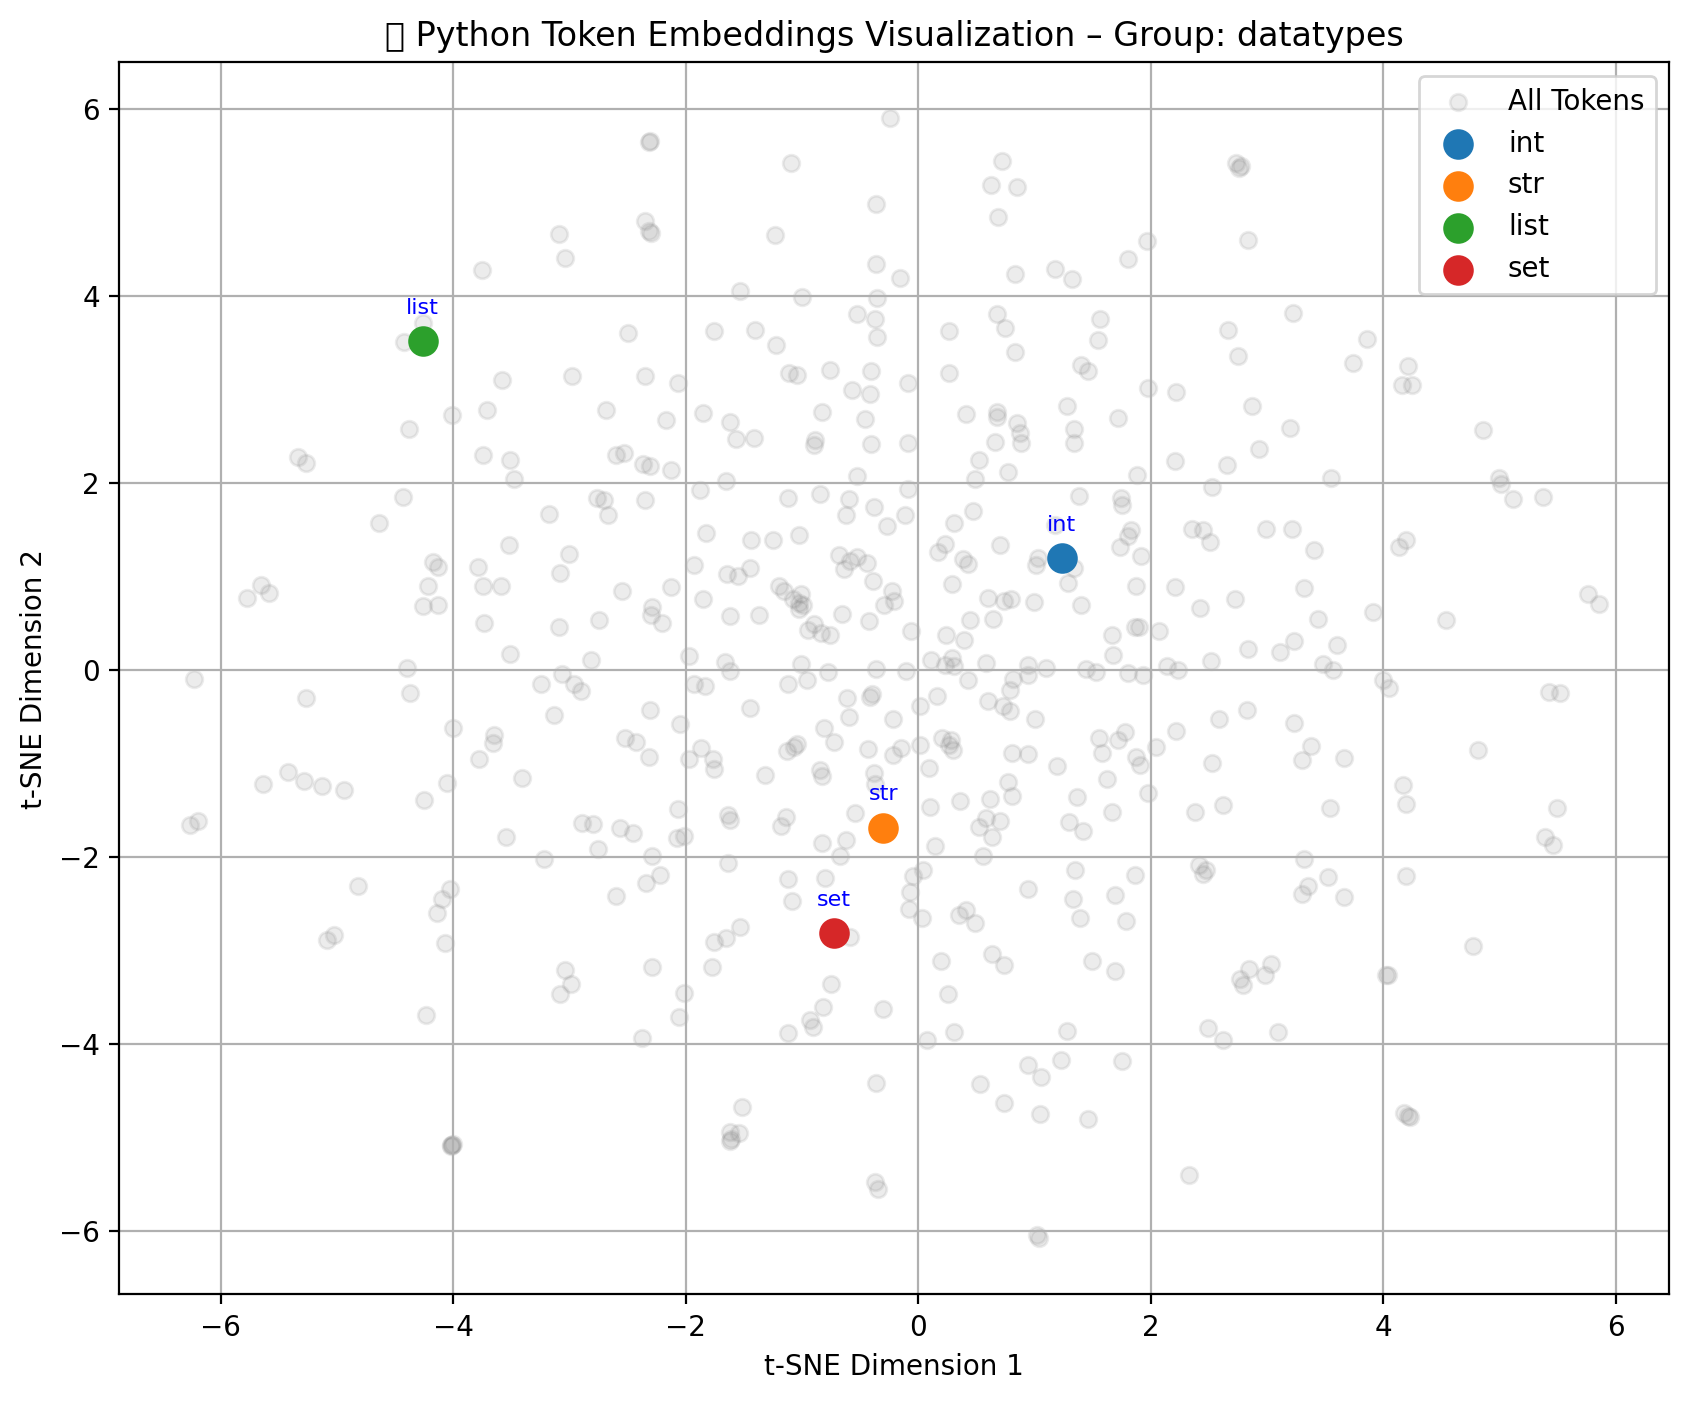

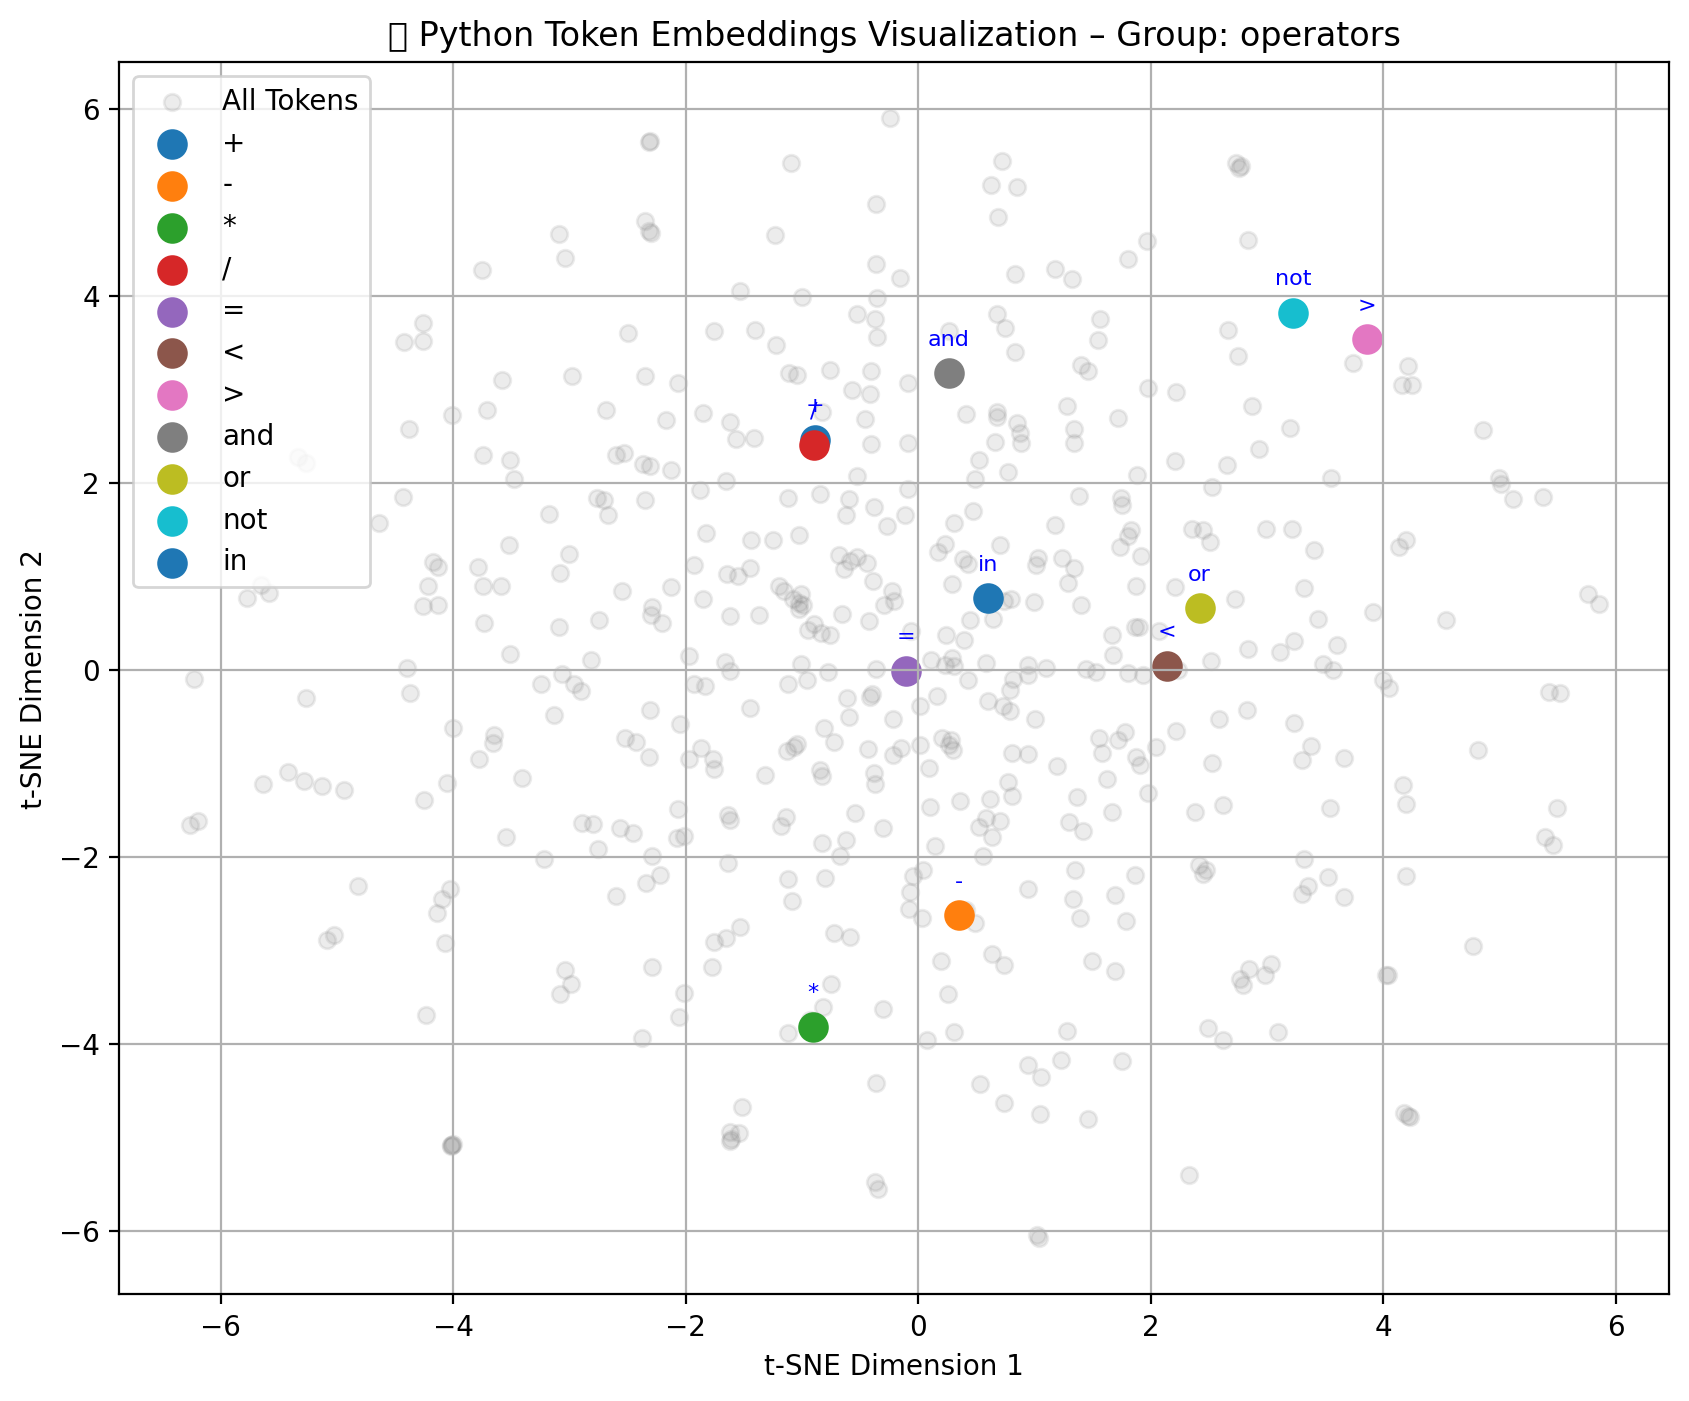

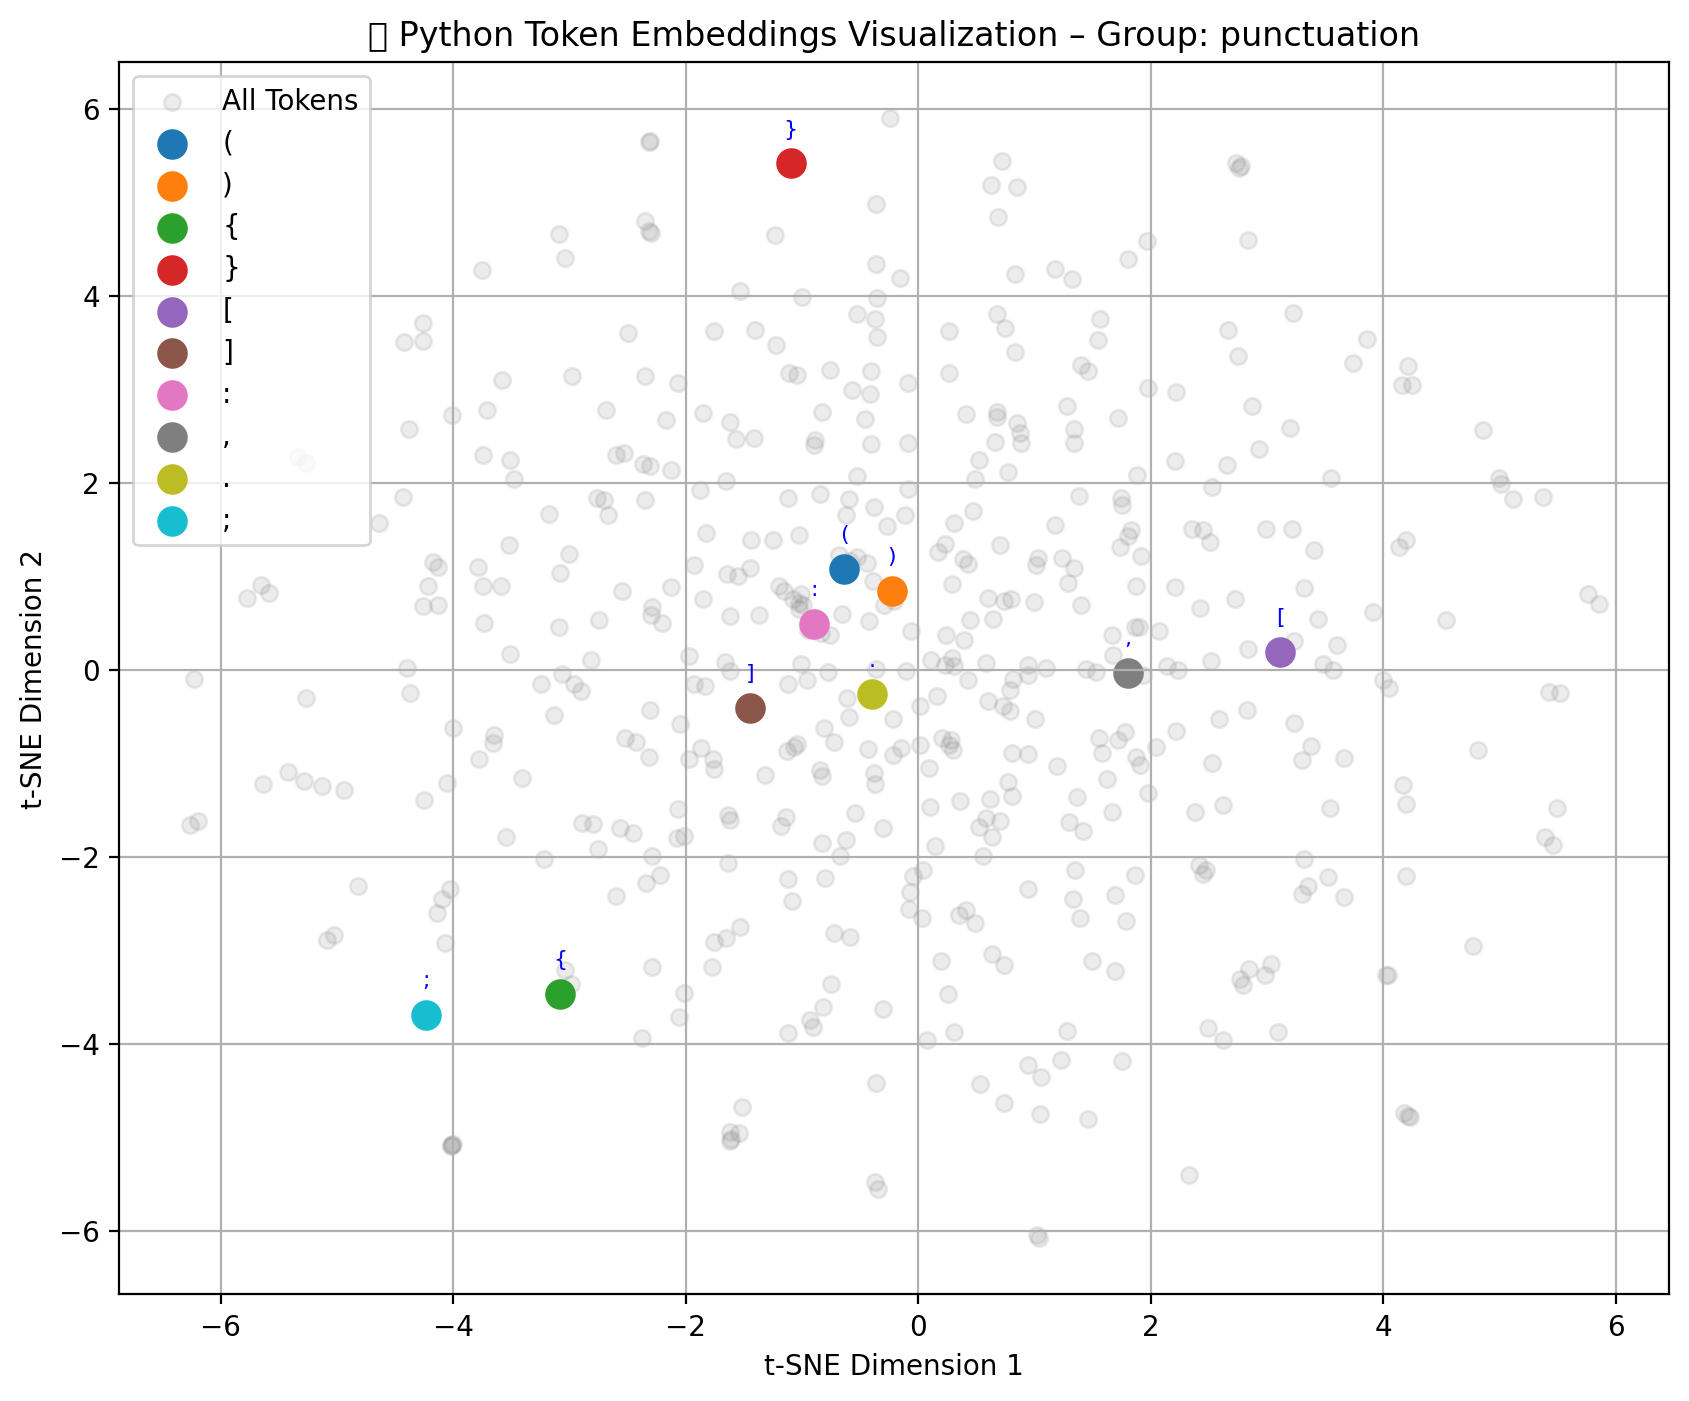

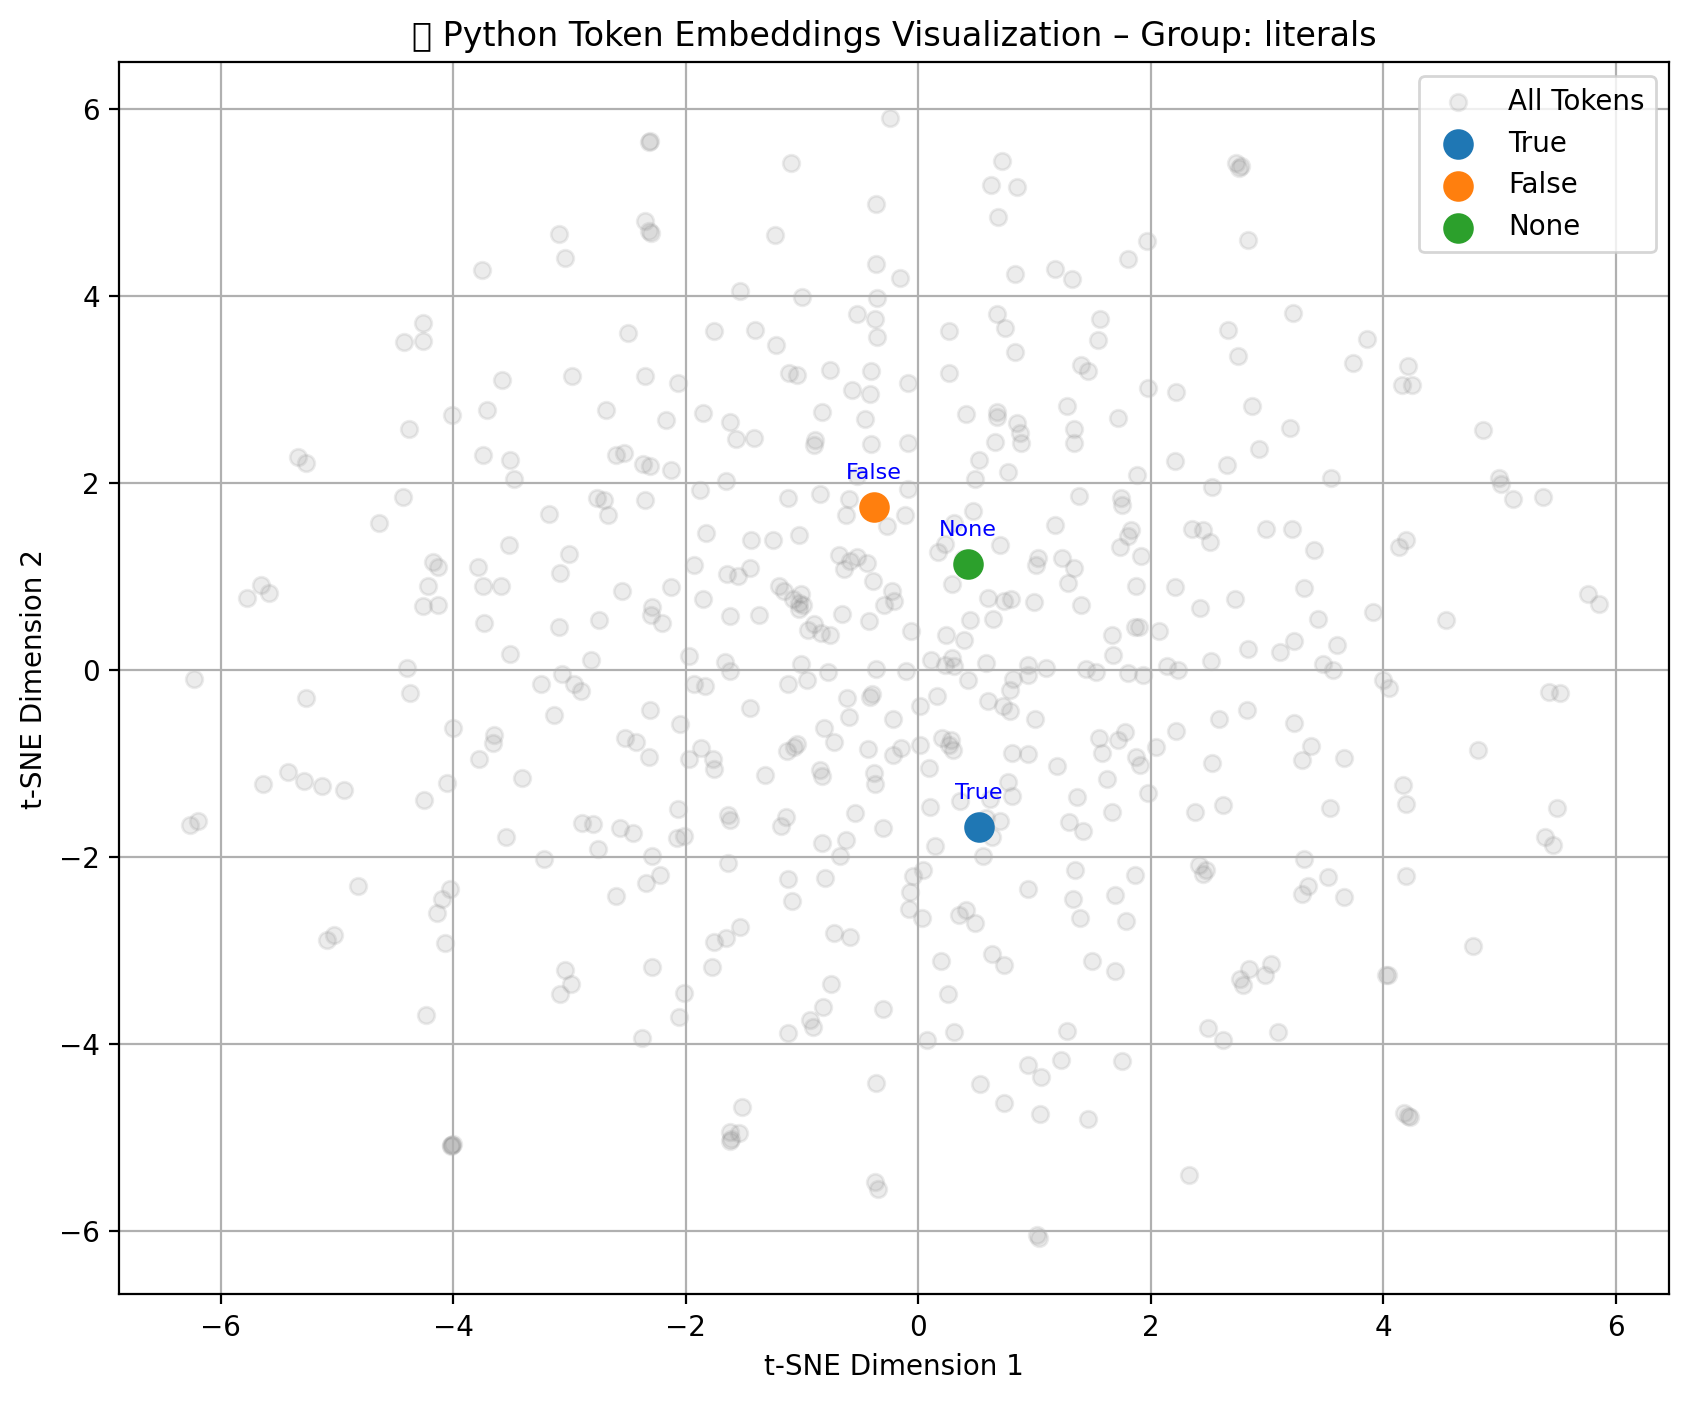

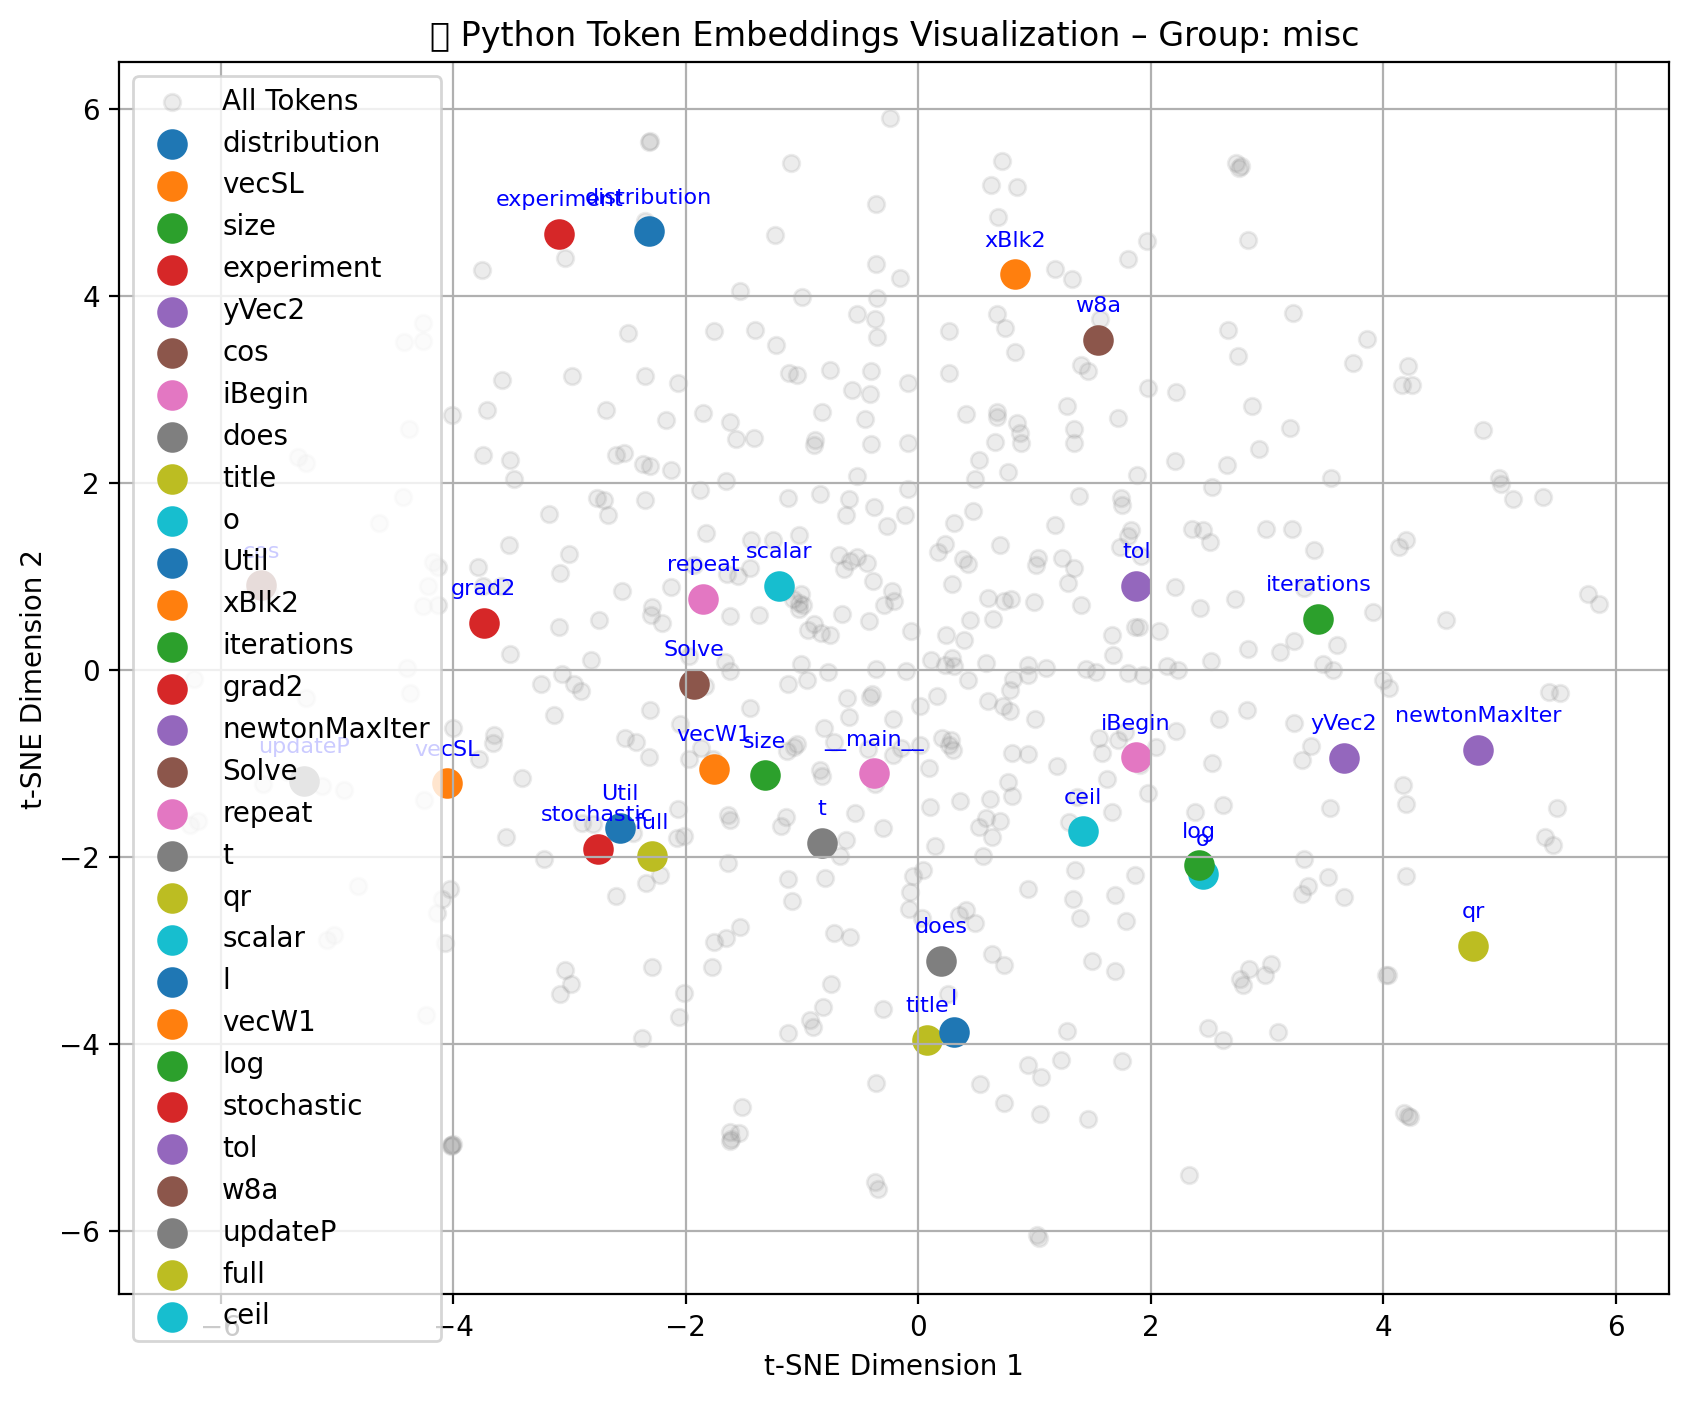

In [18]:
# ============================================================
# 1️⃣ Imports
# ============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import pickle

# ------------------------------------------------------
# 2️⃣ Device setup
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------
# 3️⃣ Define the model class (same as training)
# ------------------------------------------------------
class NextTokenPredictor(torch.nn.Module):
    def __init__(self, vocab_size, context_size, embed_dim=64, hidden_dim=256):
        super().__init__()
        self.embed = torch.nn.Embedding(vocab_size, embed_dim)
        self.fc1 = torch.nn.Linear(context_size * embed_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, vocab_size)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.embed(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------------------------------------------
# 4️⃣ Load vocab dictionaries
# ------------------------------------------------------
# Save these earlier if not already done:
with open("stoi_python.pkl", "wb") as f:
    pickle.dump(stoi, f)
with open("itos_python.pkl", "wb") as f:
    pickle.dump(itos, f)

# Load them back for visualization
with open("stoi_python.pkl", "rb") as f:
    stoi = pickle.load(f)
with open("itos_python.pkl", "rb") as f:
    itos = pickle.load(f)

vocab_size = len(stoi)
context_size = 5

# ------------------------------------------------------
# 5️⃣ Safe model load (PyTorch ≥ 2.6)
# ------------------------------------------------------
import torch.serialization
torch.serialization.add_safe_globals([NextTokenPredictor])

model = torch.load("python_model1.pt", map_location=device, weights_only=False)
model.to(device)
model.eval()

print("✅ Python model loaded successfully!")
print("Embedding size:", model.embed.weight.shape)

# ------------------------------------------------------
# 6️⃣ Extract embeddings
# ------------------------------------------------------
embedding_weights = model.embed.weight.data.cpu().numpy()
print("Embedding matrix shape:", embedding_weights.shape)

# ------------------------------------------------------
# 7️⃣ Define Python token groups for visualization
# ------------------------------------------------------
def group_python_tokens(itos, stoi):
    groups = {
        "keywords": ["def", "class", "import", "for", "while", "if", "else", "elif", "try", "except", "return"],
        "datatypes": ["int", "float", "str", "list", "dict", "set", "tuple", "bool"],
        "operators": ["+", "-", "*", "/", "%", "=", "==", "!=", "<", ">", "<=", ">=", "and", "or", "not", "in"],
        "punctuation": ["(", ")", "{", "}", "[", "]", ":", ",", ".", ";"],
        "literals": ["True", "False", "None", "0", "1"],
        "misc": []
    }

    # Keep only tokens that exist in vocab
    for k, v in groups.items():
        groups[k] = [tok for tok in v if tok in stoi]

    # Randomly sample remaining tokens for misc
    remaining = [t for t in itos.values() if t not in sum(groups.values(), [])]
    if remaining:
        groups["misc"] = random.sample(remaining, min(30, len(remaining)))
    return groups

groups = group_python_tokens(itos, stoi)

# ------------------------------------------------------
# 8️⃣ Compute t-SNE
# ------------------------------------------------------
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_weights)

# Map token → 2D coordinate
token_to_coord = {itos[i]: embeddings_tsne[i] for i in range(len(itos))}

# ------------------------------------------------------
# 9️⃣ Visualize embeddings for each semantic group
# ------------------------------------------------------
for group_name, tokens in groups.items():
    if not tokens:
        continue

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                alpha=0.15, label="All Tokens", color="gray")

    for tok in tokens:
        if tok in token_to_coord:
            x, y = token_to_coord[tok]
            plt.scatter(x, y, s=100, label=tok)
            plt.annotate(tok, (x, y),
                         textcoords="offset points", xytext=(0, 10),
                         ha='center', fontsize=8, color='blue')

    plt.title(f"🐍 Python Token Embeddings Visualization – Group: {group_name}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()
